#  Crop Classification Training Pipeline

**A PCA-based Random Forest pipeline for temporal crop classification**

This notebook demonstrates how to train Random Forest models with PCA dimensionality reduction using the preprocessed data from the crop classification pipeline. It includes:

- **🔄 Automated Data Loading**: Works directly with pipeline outputs
- **🔧 Feature Engineering**: Extract temporal features (mean, std, NDVI, GNDVI)  
- **📊 PCA Dimensionality Reduction**: Principal Component Analysis for feature reduction
- **🤖 Random Forest Classification**: RF model training with PCA features
- **📈 Comprehensive Evaluation**: Confusion matrices, ROC curves, spatial error analysis
- **💾 Model Persistence**: Save trained models for production use

**Requirements**: Run the preprocessing pipeline first to generate the required data files in `../data/processed/stacked/`.

In [3]:
# Import required libraries
import os
import sys
import numpy as np
import pandas as pd
from pathlib import Path


from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import StratifiedKFold


import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm

# Set style for better plots
plt.style.use('default')
sns.set_palette("husl")

print("All libraries imported successfully!")


# CONFIGURATION - Adjust these parameters for your data


# Data paths (automatically detects pipeline outputs)
BASE_DIR = Path("..")
DATA_DIR = BASE_DIR / "data" / "processed" / "stacked"
OUTPUT_DIR = BASE_DIR / "output"
MODELS_DIR = OUTPUT_DIR / "models"
PREDICTIONS_DIR = OUTPUT_DIR / "predictions"
VISUALIZATIONS_DIR = OUTPUT_DIR / "visualizations"

# Create output directories
for directory in [MODELS_DIR, PREDICTIONS_DIR, VISUALIZATIONS_DIR]:
    directory.mkdir(parents=True, exist_ok=True)

# Model parameters
PATCH_SHAPE = (10, 10, 64, 64)  # (t, b, h, w) - adjust based on your data
N_TIME = 10                     # Number of temporal observations
N_BAND = 10                     # Number of spectral bands
PCA_VARIANCE_THRESHOLD = 0.95   # Variance threshold for PCA components

# Spectral band indices for vegetation indices (adjust for your sensor)
NIR_BAND = 9    # Near-infrared band index
RED_BAND = 6    # Red band index  
GREEN_BAND = 3  # Green band index

print(f" Using data directory: {DATA_DIR}")
print(f" Output directory: {OUTPUT_DIR}")
print(f" Expected data shape: {PATCH_SHAPE}")
print(f" Vegetation indices: NIR={NIR_BAND}, RED={RED_BAND}, GREEN={GREEN_BAND}")
print(f" PCA variance threshold: {PCA_VARIANCE_THRESHOLD}")

All libraries imported successfully!
 Using data directory: ..\data\processed\stacked
 Output directory: ..\output
 Expected data shape: (10, 10, 64, 64)
 Vegetation indices: NIR=9, RED=6, GREEN=3
 PCA variance threshold: 0.95


In [4]:
# DATA LOADING - Automatically loads pipeline outputs


def load_pipeline_data():
    """
    Load preprocessed data from the crop classification pipeline.
    
    Returns:
        tuple: (split_df, crop_mapping) where split_df contains the spatial splits
               and crop_mapping contains the class label to crop name mapping
    """
    print("Looking for pipeline output files...")
    
    # Check for required files
    split_file = DATA_DIR / "stacked_arrays_split.csv"
    full_mapping_file = DATA_DIR / "stack_mapping.csv"
    crop_mapping_file = DATA_DIR.parent / "patches" / "crop_label_mapping.csv"
    
    if not split_file.exists():
        raise FileNotFoundError(
            f"Split file not found: {split_file}\n"
            "Please run the preprocessing pipeline first:\n"
            "python main.py pipeline --vector ... --ortho-dir ... --zone-mask ..."
        )
    
    print(f" Found split file: {split_file}")
    
    # Load split assignments
    split_df = pd.read_csv(split_file)
    print(f" Loaded {len(split_df)} stacked arrays")
    
    # Load crop mapping if available
    crop_mapping = {}
    if crop_mapping_file.exists():
        mapping_df = pd.read_csv(crop_mapping_file)
        crop_mapping = dict(zip(mapping_df["crop_label"], mapping_df["crop"]))
        print(f" Loaded crop mapping: {crop_mapping}")
    else:
        print("Crop mapping file not found, using numeric labels")
    
    # Display split distribution
    split_counts = split_df["split"].value_counts()
    print(f"\n Data split distribution:")
    for split, count in split_counts.items():
        percentage = (count / len(split_df)) * 100
        print(f"  {split.capitalize()}: {count} samples ({percentage:.1f}%)")
    
    return split_df, crop_mapping

# Load the data
try:
    split_df, crop_mapping = load_pipeline_data()
    print("\n Data loading successful!")
except Exception as e:
    print(f" Error loading data: {e}")
    print("\n Troubleshooting:")
    print("1. Make sure you've run the preprocessing pipeline")
    print("2. Check that the data directory path is correct")
    print("3. Verify that stacked_arrays_split.csv exists")
    raise

Looking for pipeline output files...
 Found split file: ..\data\processed\stacked\stacked_arrays_split.csv
 Loaded 6807 stacked arrays
 Loaded crop mapping: {0: nan, 1: 'Mixture (faba)', 2: 'Mixture (wheat)', 3: 'Potato', 4: 'Soybean', 5: 'Sugar Beet', 6: 'Sugar Corn', 7: 'Summerwheat'}

 Data split distribution:
  Train: 3444 samples (50.6%)
  Val: 1682 samples (24.7%)
  Test: 1681 samples (24.7%)

 Data loading successful!


## Feature Engineering
Extract meaningful features from temporal multispectral data including statistical measures and vegetation indices.

In [5]:
# Auto-detect data parameters from the first file
def detect_data_parameters():
    """Automatically detect temporal and spectral dimensions from data."""
    sample_file = split_df.iloc[0]["output_file"]
    sample_path = DATA_DIR / sample_file
    
    if sample_path.exists():
        arr = np.load(sample_path)
        print(f" Detected array shape: {arr.shape}")
        # Assume shape is (time*bands, height, width)
        total_bands = arr.shape[0]
        height, width = arr.shape[1], arr.shape[2]
        
        # Try to infer time and bands (this might need adjustment based on your data)
        estimated_time = total_bands // N_BAND
        print(f" Estimated temporal samples: {estimated_time}")
        print(f" Expected bands per time step: {N_BAND}")
        
        return estimated_time, N_BAND, height, width
    else:
        print(f" Sample file not found: {sample_path}")
        return N_TIME, N_BAND, 64, 64

detected_time, detected_bands, patch_h, patch_w = detect_data_parameters()

 Detected array shape: (20, 64, 64)
 Estimated temporal samples: 2
 Expected bands per time step: 10


In [6]:

# FEATURE EXTRACTION - Works with any temporal dimensions

def extract_features(arr, n_time=None, n_band=None):
    """
    Extract features from temporal multispectral data.
    
    Args:
        arr: Input array with shape (time*bands, height, width)
        n_time: Number of time steps (auto-detected if None)
        n_band: Number of bands per time step (auto-detected if None)
    
    Returns:
        numpy.ndarray: Feature vector
    """
    arr = np.asarray(arr)
    
    # Auto-detect dimensions if not provided
    if n_time is None:
        n_time = detected_time
    if n_band is None:
        n_band = detected_bands
    
    # Reshape to (time, bands, height, width)
    try:
        arr = arr.reshape(n_time, n_band, arr.shape[1], arr.shape[2])
    except ValueError as e:
        print(f" Reshape error: {e}")
        print(f"Array shape: {arr.shape}, trying to reshape to ({n_time}, {n_band}, H, W)")
        # Fallback: use available dimensions
        total_time_bands = arr.shape[0]
        n_time = total_time_bands // n_band
        arr = arr[:n_time*n_band].reshape(n_time, n_band, arr.shape[1], arr.shape[2])
    
    # Extract statistical features
    mean_features = np.nanmean(arr, axis=(2, 3)).flatten()  # Mean per band per time
    std_features = np.nanstd(arr, axis=(2, 3)).flatten()    # Std per band per time
    
    # Extract vegetation indices (with error handling)
    try:
        # NDVI = (NIR - RED) / (NIR + RED)
        nir = arr[:, NIR_BAND, :, :] if NIR_BAND < n_band else arr[:, -1, :, :]
        red = arr[:, RED_BAND, :, :] if RED_BAND < n_band else arr[:, n_band//2, :, :]
        ndvi = (nir - red) / (nir + red + 1e-8)
        ndvi_features = np.nanmean(ndvi, axis=(1, 2))
        
        # GNDVI = (NIR - GREEN) / (NIR + GREEN)  
        green = arr[:, GREEN_BAND, :, :] if GREEN_BAND < n_band else arr[:, n_band//3, :, :]
        gndvi = (nir - green) / (nir + green + 1e-8)
        gndvi_features = np.nanmean(gndvi, axis=(1, 2))
        
    except Exception as e:
        print(f" Error computing vegetation indices: {e}")
        # Fallback: use zeros
        ndvi_features = np.zeros(n_time)
        gndvi_features = np.zeros(n_time)
    
    # Combine all features
    features = np.concatenate([mean_features, std_features, ndvi_features, gndvi_features])
    
    # Handle NaN values
    features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
    
    return features

print(" Feature extraction function ready!")
print(f" Expected feature dimensions:")
print(f"  - Mean features: {detected_time * detected_bands}")
print(f"  - Std features: {detected_time * detected_bands}")  
print(f"  - NDVI features: {detected_time}")
print(f"  - GNDVI features: {detected_time}")
print(f"  - Total features: {2 * detected_time * detected_bands + 2 * detected_time}")

 Feature extraction function ready!
 Expected feature dimensions:
  - Mean features: 20
  - Std features: 20
  - NDVI features: 2
  - GNDVI features: 2
  - Total features: 44


In [7]:
# DATA PROCESSING - Extract features and create splits


def process_all_data(split_df):
    """
    Process all data files and extract features.
    
    Args:
        split_df: DataFrame with file paths and split assignments
        
    Returns:
        tuple: (features, labels, splits, feature_names, sample_ids)
    """
    print(" Processing all data files...")
    
    features_list = []
    labels_list = []
    splits_list = []
    sample_ids_list = []
    
    # Process each file
    for idx, row in tqdm(split_df.iterrows(), total=len(split_df), desc="Processing files"):
        try:
            # Load array
            file_path = DATA_DIR / row['output_file']
            if not file_path.exists():
                print(f" File not found: {file_path}")
                continue
                
            arr = np.load(file_path)
            
            # Extract features
            features = extract_features(arr)
            features_list.append(features)
            
            # Extract label from filename (assumes format: patch_id_classX.npy)
            filename = row['output_file']
            if '_class' in filename:
                label = int(filename.split('_class')[1].split('.')[0])
            else:
                label = 0  # Default label
            labels_list.append(label)
            
            # Store split and sample ID
            splits_list.append(row['split'])
            sample_ids_list.append(filename)
            
        except Exception as e:
            print(f" Error processing {row['output_file']}: {e}")
            continue
    
    # Convert to arrays
    features = np.array(features_list)
    labels = np.array(labels_list) 
    splits = np.array(splits_list)
    sample_ids = np.array(sample_ids_list)
    
    # Create feature names
    n_time = detected_time
    n_band = detected_bands
    feature_names = []
    feature_names.extend([f"mean_t{t}_b{b}" for t in range(n_time) for b in range(n_band)])
    feature_names.extend([f"std_t{t}_b{b}" for t in range(n_time) for b in range(n_band)])
    feature_names.extend([f"ndvi_t{t}" for t in range(n_time)])
    feature_names.extend([f"gndvi_t{t}" for t in range(n_time)])
    
    print(f" Processed {len(features)} samples")
    print(f" Feature shape: {features.shape}")
    print(f" Unique labels: {np.unique(labels)}")
    print(f" Split distribution: {np.unique(splits, return_counts=True)}")
    
    return features, labels, splits, feature_names, sample_ids

# Process all data
features, labels, splits, feature_names, sample_ids = process_all_data(split_df)

# Create crop mapping display
unique_labels = np.unique(labels)
print(f"\n Class mapping:")
for label in unique_labels:
    crop_name = crop_mapping.get(label, f"Class_{label}")
    count = np.sum(labels == label)
    print(f"  Class {label}: {crop_name} ({count} samples)")

 Processing all data files...


Processing files: 100%|██████████| 6807/6807 [00:07<00:00, 950.61it/s]

 Processed 6807 samples
 Feature shape: (6807, 44)
 Unique labels: [0 3 4 5 6 7]
 Split distribution: (array(['test', 'train', 'val'], dtype='<U5'), array([1681, 3444, 1682]))

 Class mapping:
  Class 0: nan (1064 samples)
  Class 3: Potato (1290 samples)
  Class 4: Soybean (645 samples)
  Class 5: Sugar Beet (1252 samples)
  Class 6: Sugar Corn (1283 samples)
  Class 7: Summerwheat (1273 samples)


 Creating spatial data splits...
 Split sizes:
  Training: 3444 samples
  Validation: 1682 samples
  Test: 1681 samples

 Train class distribution:
  nan: 544 (15.8%)
  Potato: 647 (18.8%)
  Soybean: 324 (9.4%)
  Sugar Beet: 636 (18.5%)
  Sugar Corn: 648 (18.8%)
  Summerwheat: 645 (18.7%)

 Val class distribution:
  nan: 270 (16.1%)
  Potato: 326 (19.4%)
  Soybean: 163 (9.7%)
  Sugar Beet: 296 (17.6%)
  Sugar Corn: 315 (18.7%)
  Summerwheat: 312 (18.5%)

 Test class distribution:
  nan: 250 (14.9%)
  Potato: 317 (18.9%)
  Soybean: 158 (9.4%)
  Sugar Beet: 320 (19.0%)
  Sugar Corn: 320 (19.0%)
  Summerwheat: 316 (18.8%)


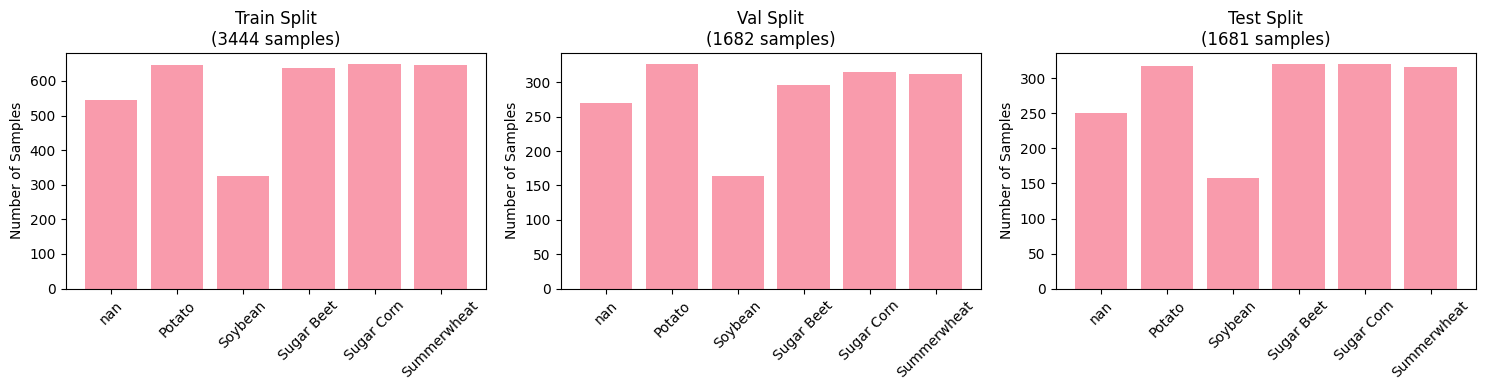

 Spatial splits created successfully!


In [9]:
# DATA SPLITTING - Use pipeline's spatial splits


def create_spatial_splits(features, labels, splits, sample_ids):
    """
    Create spatially-aware train/val/test splits using pipeline assignments.
    
    Returns:
        dict: Dictionary containing split data
    """
    print(" Creating spatial data splits...")
    
    # Split data based on pipeline assignments
    train_mask = splits == "train"
    val_mask = splits == "val" 
    test_mask = splits == "test"
    
    split_data = {
        'X_train': features[train_mask],
        'y_train': labels[train_mask],
        'X_val': features[val_mask],
        'y_val': labels[val_mask], 
        'X_test': features[test_mask],
        'y_test': labels[test_mask],
        'id_train': sample_ids[train_mask],
        'id_val': sample_ids[val_mask],
        'id_test': sample_ids[test_mask]
    }
    
    # Print split statistics
    print(f" Split sizes:")
    print(f"  Training: {len(split_data['X_train'])} samples")
    print(f"  Validation: {len(split_data['X_val'])} samples") 
    print(f"  Test: {len(split_data['X_test'])} samples")
    
    # Check class distribution per split
    for split_name, y_data in [('train', split_data['y_train']), 
                               ('val', split_data['y_val']),
                               ('test', split_data['y_test'])]:
        unique, counts = np.unique(y_data, return_counts=True)
        print(f"\n {split_name.capitalize()} class distribution:")
        for label, count in zip(unique, counts):
            crop_name = crop_mapping.get(label, f"Class_{label}")
            percentage = (count / len(y_data)) * 100
            print(f"  {crop_name}: {count} ({percentage:.1f}%)")
    
    return split_data

# Create splits
split_data = create_spatial_splits(features, labels, splits, sample_ids)

# Visualize class distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
splits_to_plot = [('train', split_data['y_train']), 
                  ('val', split_data['y_val']),
                  ('test', split_data['y_test'])]

for i, (split_name, y_data) in enumerate(splits_to_plot):
    unique, counts = np.unique(y_data, return_counts=True)
    # Fix the crop names to ensure they are strings
    crop_names = [str(crop_mapping.get(label, f"Class_{label}")) for label in unique]
    
    axes[i].bar(crop_names, counts, alpha=0.7)
    axes[i].set_title(f'{split_name.capitalize()} Split\n({len(y_data)} samples)')
    axes[i].set_ylabel('Number of Samples')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig(VISUALIZATIONS_DIR / "class_distribution_by_split.png", dpi=300, bbox_inches='tight')
plt.show()

print(" Spatial splits created successfully!")

In [10]:
# DATA PREPROCESSING - Imputation, Outlier Handling, Scaling


def preprocess_features(X_train, X_val, X_test, feature_names):
    """
    Preprocess features with imputation, outlier handling, and scaling.
    
    Returns:
        tuple: (X_train_processed, X_val_processed, X_test_processed, preprocessors)
    """
    print("🔧 Preprocessing features...")
    
    # 1. Imputation (fill missing values with median)
    print("  Handling missing values...")
    nan_count_train = np.isnan(X_train).sum()
    print(f"     Training NaNs: {nan_count_train} ({nan_count_train/X_train.size*100:.2f}%)")
    
    imputer = SimpleImputer(strategy='median')
    X_train_imp = imputer.fit_transform(X_train)
    X_val_imp = imputer.transform(X_val)
    X_test_imp = imputer.transform(X_test)
    
    # 2. Outlier handling (cap at 99th percentile)
    print("  Handling outliers...")
    q_99 = np.percentile(X_train_imp, 99, axis=0)
    
    outliers_train = np.sum(X_train_imp > q_99)
    outliers_val = np.sum(X_val_imp > q_99)
    outliers_test = np.sum(X_test_imp > q_99)
    
    print(f"     Outliers capped - Train: {outliers_train}, Val: {outliers_val}, Test: {outliers_test}")
    
    X_train_imp = np.minimum(X_train_imp, q_99)
    X_val_imp = np.minimum(X_val_imp, q_99)
    X_test_imp = np.minimum(X_test_imp, q_99)
    
    # 3. Standardization
    print("  Standardizing features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_imp)
    X_val_scaled = scaler.transform(X_val_imp)
    X_test_scaled = scaler.transform(X_test_imp)
    
    preprocessors = {
        'imputer': imputer,
        'scaler': scaler,
        'outlier_threshold': q_99
    }
    
    print(" Preprocessing complete!")
    
    return X_train_scaled, X_val_scaled, X_test_scaled, preprocessors

# Apply preprocessing
X_train_scaled, X_val_scaled, X_test_scaled, preprocessors = preprocess_features(
    split_data['X_train'], split_data['X_val'], split_data['X_test'], feature_names
)

print(f" Preprocessed data shapes:")
print(f"  Training: {X_train_scaled.shape}")
print(f"  Validation: {X_val_scaled.shape}")
print(f"  Test: {X_test_scaled.shape}")

# Update split_data with preprocessed features
split_data.update({
    'X_train_scaled': X_train_scaled,
    'X_val_scaled': X_val_scaled,
    'X_test_scaled': X_test_scaled,
    'preprocessors': preprocessors
})

🔧 Preprocessing features...
  Handling missing values...
     Training NaNs: 0 (0.00%)
  Handling outliers...
     Outliers capped - Train: 1540, Val: 985, Test: 1371
  Standardizing features...
 Preprocessing complete!
 Preprocessed data shapes:
  Training: (3444, 44)
  Validation: (1682, 44)
  Test: (1681, 44)


 Using 5 PCA components to explain 95% of variance

 Top contributing features for first 3 PCA components:

  PC1 (explains 47.4% variance):
    gndvi_t1: 0.211
    mean_t1_b5: -0.210
    mean_t1_b4: -0.210
    ndvi_t1: 0.209
    ndvi_t0: 0.205

  PC2 (explains 34.2% variance):
    std_t0_b1: 0.238
    std_t0_b0: 0.237
    std_t0_b6: 0.230
    std_t0_b5: 0.229
    std_t0_b4: 0.225

  PC3 (explains 9.2% variance):
    mean_t0_b8: 0.349
    mean_t1_b8: 0.347
    mean_t0_b7: 0.309
    mean_t0_b9: 0.277
    mean_t1_b9: 0.275


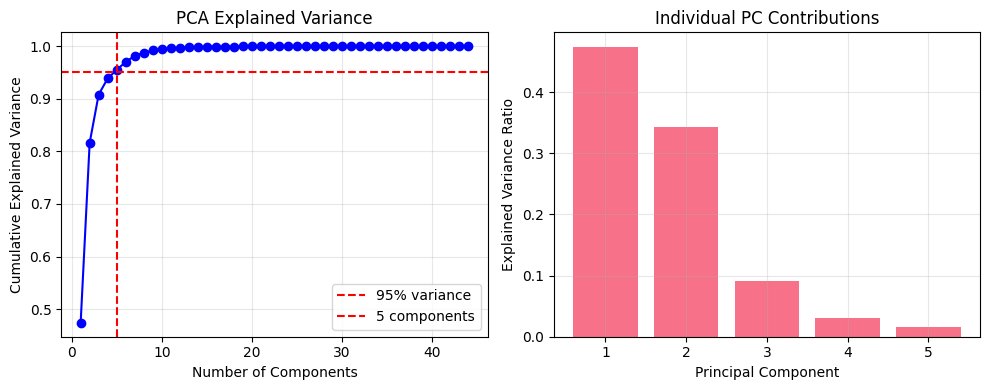

 PCA complete! Reduced from 44 to 5 components.


In [11]:
# PCA DIMENSIONALITY REDUCTION 



# Fit PCA to explain 95% of variance
pca_full = PCA().fit(X_train_scaled)
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components = np.searchsorted(cumulative_variance, 0.95) + 1

print(f" Using {n_components} PCA components to explain 95% of variance")

# Apply PCA transformation
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Show which original features contribute most to each PC
print(f"\n Top contributing features for first 3 PCA components:")
for i in range(min(3, n_components)):
    component = pca.components_[i]
    top_features_idx = np.argsort(np.abs(component))[::-1][:5]
    print(f"\n  PC{i+1} (explains {pca.explained_variance_ratio_[i]:.1%} variance):")
    for idx in top_features_idx:
        print(f"    {feature_names[idx]}: {component[idx]:.3f}")

# Plot explained variance
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(cumulative_variance[:50]) + 1), cumulative_variance[:50], 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
plt.axvline(x=n_components, color='r', linestyle='--', label=f'{n_components} components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(range(1, min(20, len(pca.explained_variance_ratio_)) + 1), 
        pca.explained_variance_ratio_[:min(20, len(pca.explained_variance_ratio_))])
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Individual PC Contributions')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(VISUALIZATIONS_DIR / "pca_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print(f" PCA complete! Reduced from {len(feature_names)} to {n_components} components.")

In [13]:
# RANDOM FOREST TRAINING WITH PCA


def train_pca_random_forest(X_train, X_val, X_test, y_train, y_val, y_test, variance_threshold=0.95):
    """
    Train Random Forest model using PCA-transformed features
    
    Args:
        X_train, X_val, X_test: Preprocessed feature arrays
        y_train, y_val, y_test: Label arrays
        variance_threshold: Minimum variance to retain with PCA
        
    Returns:
        dict: Contains trained model, transformers, predictions, and performance metrics
    """
    print("🔄 Training Random Forest with PCA...")
    
    # 1. Determine optimal number of PCA components
    pca_full = PCA().fit(X_train)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)
    n_components = np.searchsorted(cumulative_variance, variance_threshold) + 1
    
    print(f"   ✓ Using {n_components} PCA components to retain {variance_threshold*100:.1f}% variance")
    
    # 2. Apply PCA transformation
    pca = PCA(n_components=n_components, random_state=42)
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    print(f"   ✓ Actual explained variance: {pca.explained_variance_ratio_.sum():.1%}")
    
    # 3. Train Random Forest on PCA features
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        random_state=42,
        n_jobs=-1,
        oob_score=True
    )
    
    rf_model.fit(X_train_pca, y_train)
    
    print(f"   ✓ Model training complete! OOB Score: {rf_model.oob_score_:.3f}")
    
    # 4. Make predictions
    y_train_pred = rf_model.predict(X_train_pca)
    y_val_pred = rf_model.predict(X_val_pca)
    y_test_pred = rf_model.predict(X_test_pca)
    
    # 5. Calculate performance metrics
    results = {
        'model': rf_model,
        'pca_transformer': pca,
        'transformed_data': {
            'X_train_pca': X_train_pca,
            'X_val_pca': X_val_pca,
            'X_test_pca': X_test_pca
        },
        'predictions': {
            'train': y_train_pred,
            'val': y_val_pred,
            'test': y_test_pred
        },
        'metrics': {
            'oob_score': rf_model.oob_score_,
            'train_accuracy': accuracy_score(y_train, y_train_pred),
            'val_accuracy': accuracy_score(y_val, y_val_pred),
            'test_accuracy': accuracy_score(y_test, y_test_pred),
            'train_f1': f1_score(y_train, y_train_pred, average='weighted'),
            'val_f1': f1_score(y_val, y_val_pred, average='weighted'),
            'test_f1': f1_score(y_test, y_test_pred, average='weighted')
        },
        'pca_info': {
            'n_components': n_components,
            'explained_variance_ratio': pca.explained_variance_ratio_,
            'cumulative_variance': np.cumsum(pca.explained_variance_ratio_)
        }
    }
    
    # Print performance summary
    print("\n Model Performance Summary:")
    print("="*50)
    print(f" PCA Components: {n_components} (explaining {pca.explained_variance_ratio_.sum():.1%} variance)")
    print(f" Training Accuracy:   {results['metrics']['train_accuracy']:.4f}")
    print(f" Validation Accuracy: {results['metrics']['val_accuracy']:.4f}")
    print(f" Test Accuracy:       {results['metrics']['test_accuracy']:.4f}")
    print(f" Test F1-Score:       {results['metrics']['test_f1']:.4f}")
    print(f" OOB Score:          {results['metrics']['oob_score']:.4f}")
    
    return results

# Train the PCA Random Forest model
model_results = train_pca_random_forest(
    X_train_scaled, X_val_scaled, X_test_scaled,
    split_data['y_train'], split_data['y_val'], split_data['y_test'],
    variance_threshold=PCA_VARIANCE_THRESHOLD
)

🔄 Training Random Forest with PCA...
   ✓ Using 5 PCA components to retain 95.0% variance
   ✓ Actual explained variance: 95.5%
   ✓ Model training complete! OOB Score: 0.888

 Model Performance Summary:
 PCA Components: 5 (explaining 95.5% variance)
 Training Accuracy:   1.0000
 Validation Accuracy: 0.8246
 Test Accuracy:       0.7555
 Test F1-Score:       0.7609
 OOB Score:          0.8876
   ✓ Model training complete! OOB Score: 0.888

 Model Performance Summary:
 PCA Components: 5 (explaining 95.5% variance)
 Training Accuracy:   1.0000
 Validation Accuracy: 0.8246
 Test Accuracy:       0.7555
 Test F1-Score:       0.7609
 OOB Score:          0.8876


##  Model Evaluation & Analysis

g:\Uni Master Programmierprojekte\DoppelModulData\1\cutting-and-label\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Uni Master Programmierprojekte\DoppelModulData\1\cutting-and-label\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
g:\Uni Master Programmierprojekte\DoppelModulData\1\cutting-and-label\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero

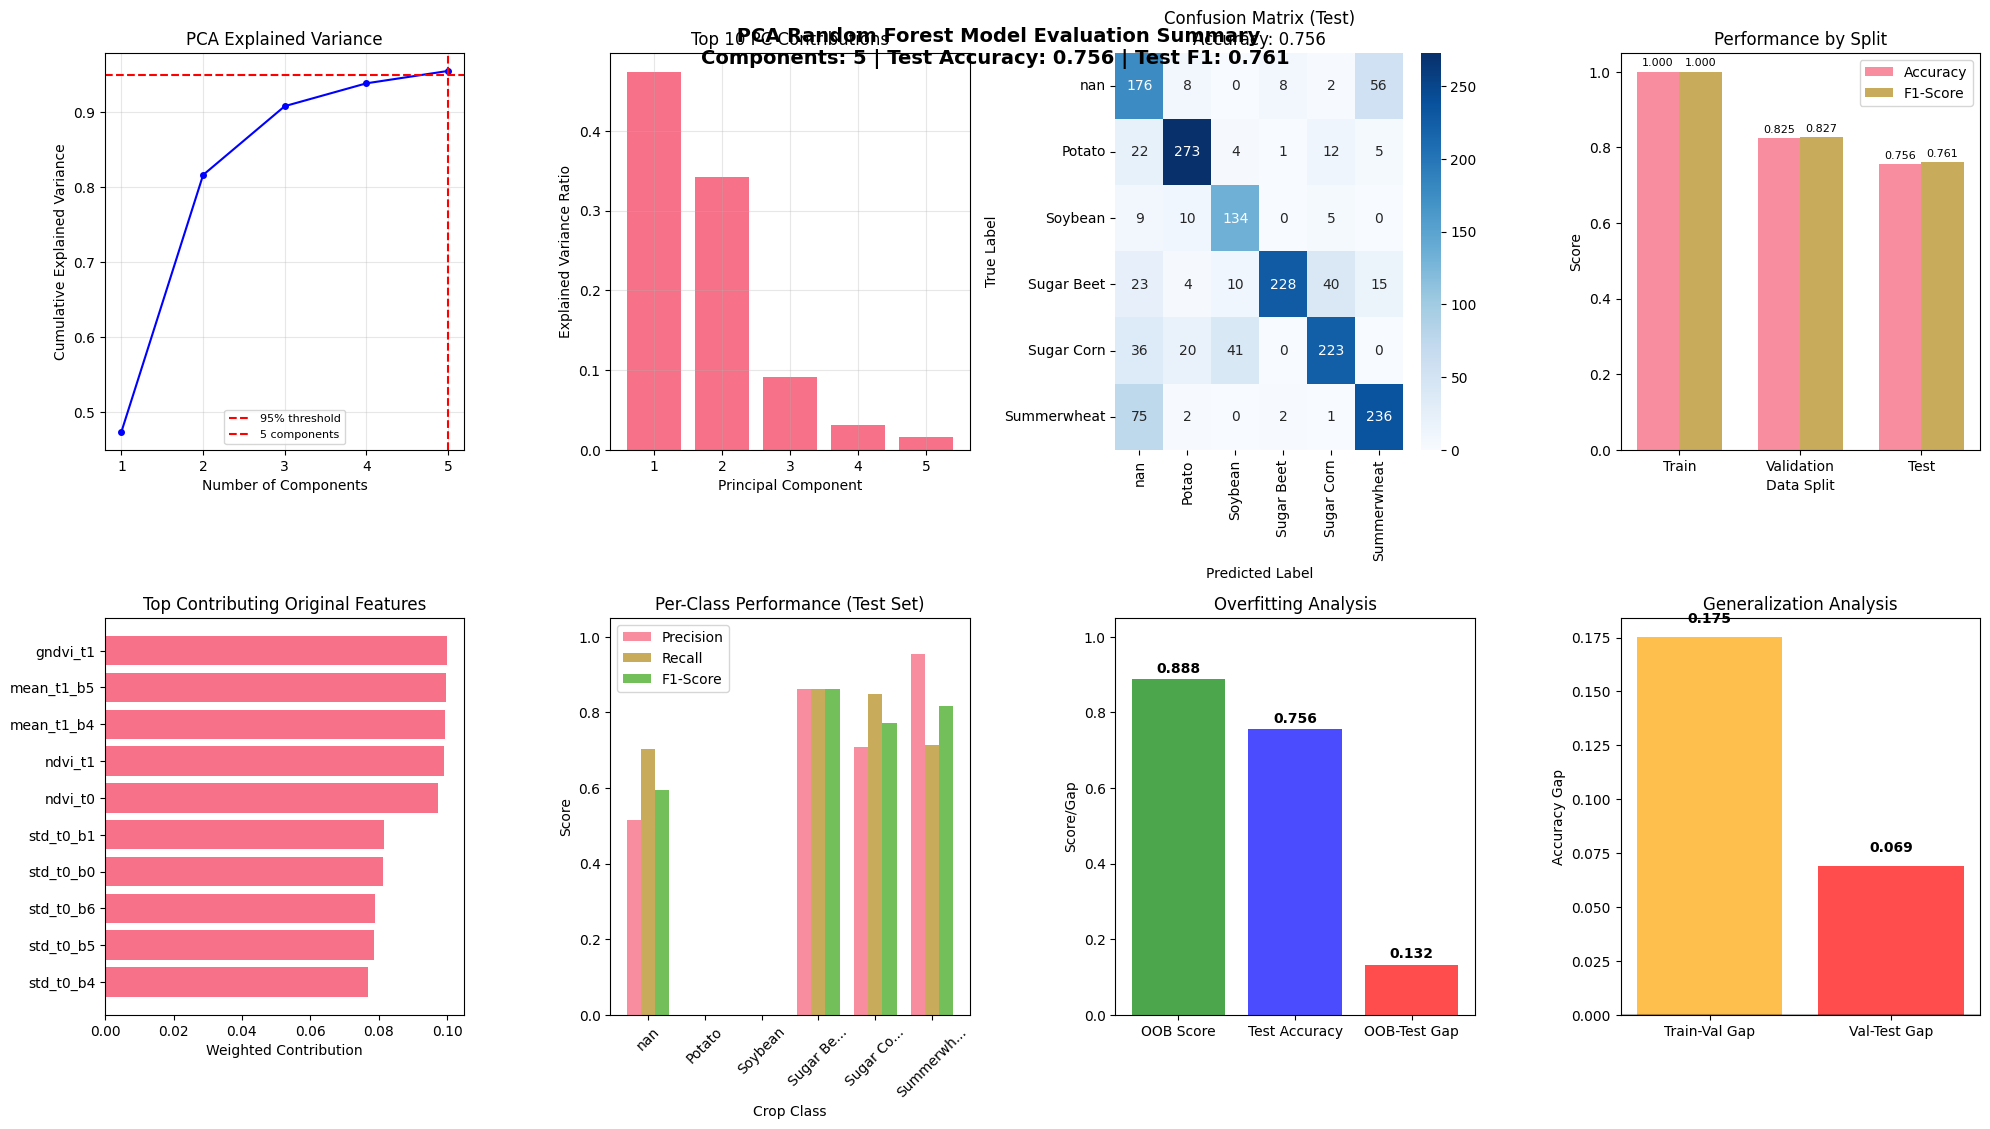


 Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         nan       0.52      0.70      0.60       250
      Potato       0.86      0.86      0.86       317
     Soybean       0.71      0.85      0.77       158
  Sugar Beet       0.95      0.71      0.82       320
  Sugar Corn       0.79      0.70      0.74       320
 Summerwheat       0.76      0.75      0.75       316

    accuracy                           0.76      1681
   macro avg       0.76      0.76      0.76      1681
weighted avg       0.78      0.76      0.76      1681



In [15]:
# COMPREHENSIVE MODEL EVALUATION

# Create class names list from the unique labels
unique_labels = np.unique(labels)
crop_mapping_display = [str(crop_mapping.get(label, f"Class_{label}")) for label in unique_labels]

# Extract y variables from split_data
y_train = split_data['y_train']
y_val = split_data['y_val'] 
y_test = split_data['y_test']

def evaluate_pca_model(model_results, class_names, y_train, y_val, y_test):
    """
    Create comprehensive evaluation plots and metrics for PCA Random Forest model
    
    Args:
        model_results: Results from train_pca_random_forest function
        class_names: List of class names for visualization
        y_train, y_val, y_test: True labels for each split
    """
    
    # Extract data from results
    model = model_results['model']
    pca = model_results['pca_transformer']
    predictions = model_results['predictions']
    metrics = model_results['metrics']
    pca_info = model_results['pca_info']
    
    # Create comprehensive figure
    fig = plt.figure(figsize=(20, 16))
    
    # 1. PCA Explained Variance
    plt.subplot(3, 4, 1)
    plt.plot(range(1, len(pca_info['cumulative_variance']) + 1), 
             pca_info['cumulative_variance'], 'bo-', markersize=4)
    plt.axhline(y=PCA_VARIANCE_THRESHOLD, color='r', linestyle='--', 
                label=f'{PCA_VARIANCE_THRESHOLD*100:.0f}% threshold')
    plt.axvline(x=pca_info['n_components'], color='r', linestyle='--', 
                label=f'{pca_info["n_components"]} components')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('PCA Explained Variance')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # 2. Individual PC Contributions (first 10)
    plt.subplot(3, 4, 2)
    n_show = min(10, len(pca_info['explained_variance_ratio']))
    plt.bar(range(1, n_show + 1), pca_info['explained_variance_ratio'][:n_show])
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Top 10 PC Contributions')
    plt.grid(True, alpha=0.3)
    
    # 3. Confusion Matrix - Test Set
    from sklearn.metrics import confusion_matrix
    plt.subplot(3, 4, 3)
    cm_test = confusion_matrix(y_test, predictions['test'])
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix (Test)\nAccuracy: {metrics["test_accuracy"]:.3f}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
    # 4. Performance by Split
    plt.subplot(3, 4, 4)
    splits = ['Train', 'Validation', 'Test']
    accuracies = [metrics['train_accuracy'], metrics['val_accuracy'], metrics['test_accuracy']]
    f1_scores = [metrics['train_f1'], metrics['val_f1'], metrics['test_f1']]
    
    x = np.arange(len(splits))
    width = 0.35
    plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.8)
    plt.bar(x + width/2, f1_scores, width, label='F1-Score', alpha=0.8)
    
    plt.xlabel('Data Split')
    plt.ylabel('Score')
    plt.title('Performance by Split')
    plt.xticks(x, splits)
    plt.legend()
    plt.ylim(0, 1.05)
    
    # Add value labels on bars
    for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
        plt.text(i - width/2, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontsize=8)
        plt.text(i + width/2, f1 + 0.01, f'{f1:.3f}', ha='center', va='bottom', fontsize=8)
    
    # 5. Feature Importance (for original features in top PCs)
    plt.subplot(3, 4, 5)
    # Show which original features contribute most to first 3 PCs
    top_contributors = {}
    for i in range(min(3, pca_info['n_components'])):
        component = pca.components_[i]
        top_idx = np.argsort(np.abs(component))[-5:][::-1]
        for idx in top_idx:
            if idx not in top_contributors:
                top_contributors[idx] = 0
            top_contributors[idx] += np.abs(component[idx]) * pca_info['explained_variance_ratio'][i]
    
    # Plot top contributing features
    sorted_contributors = sorted(top_contributors.items(), key=lambda x: x[1], reverse=True)[:10]
    indices, contributions = zip(*sorted_contributors)
    
    plt.barh(range(len(indices)), contributions)
    feature_names_display = [feature_names[i] if i < len(feature_names) else f"Feature_{i}" for i in indices]
    plt.yticks(range(len(indices)), feature_names_display)
    plt.xlabel('Weighted Contribution')
    plt.title('Top Contributing Original Features')
    plt.gca().invert_yaxis()
    
    # 6. Class-wise Performance
    plt.subplot(3, 4, 6)
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        y_test, predictions['test'], average=None, labels=range(len(class_names))
    )
    
    x = np.arange(len(class_names))
    width = 0.25
    plt.bar(x - width, precision, width, label='Precision', alpha=0.8)
    plt.bar(x, recall, width, label='Recall', alpha=0.8)
    plt.bar(x + width, f1, width, label='F1-Score', alpha=0.8)
    
    plt.xlabel('Crop Class')
    plt.ylabel('Score')
    plt.title('Per-Class Performance (Test Set)')
    plt.xticks(x, [name[:8] + '...' if len(name) > 8 else name for name in class_names], rotation=45)
    plt.legend()
    plt.ylim(0, 1.05)
    
    # 7. Residual Analysis (OOB vs Test performance)
    plt.subplot(3, 4, 7)
    oob_gap = metrics['oob_score'] - metrics['test_accuracy']
    splits_gap = ['OOB Score', 'Test Accuracy', 'OOB-Test Gap']
    values_gap = [metrics['oob_score'], metrics['test_accuracy'], abs(oob_gap)]
    colors = ['green' if oob_gap >= 0 else 'orange', 'blue', 'red' if abs(oob_gap) > 0.05 else 'orange']
    
    plt.bar(splits_gap[:2], values_gap[:2], color=colors[:2], alpha=0.7)
    plt.bar(splits_gap[2], values_gap[2], color=colors[2], alpha=0.7)
    plt.ylabel('Score/Gap')
    plt.title('Overfitting Analysis')
    plt.ylim(0, max(1.05, max(values_gap) + 0.1))
    
    # Add value labels
    for i, v in enumerate(values_gap):
        plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 8. Learning Curve Simulation (using validation scores)
    plt.subplot(3, 4, 8)
    # Simple representation of generalization
    train_val_gap = metrics['train_accuracy'] - metrics['val_accuracy']
    val_test_gap = metrics['val_accuracy'] - metrics['test_accuracy']
    
    plt.bar(['Train-Val Gap', 'Val-Test Gap'], [train_val_gap, val_test_gap], 
            color=['orange', 'red'], alpha=0.7)
    plt.ylabel('Accuracy Gap')
    plt.title('Generalization Analysis')
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    for i, gap in enumerate([train_val_gap, val_test_gap]):
        plt.text(i, gap + 0.005 if gap >= 0 else gap - 0.01, 
                f'{gap:.3f}', ha='center', va='bottom' if gap >= 0 else 'top', fontweight='bold')
    
    plt.tight_layout()
    plt.suptitle(f' PCA Random Forest Model Evaluation Summary\n'
                f'Components: {pca_info["n_components"]} | Test Accuracy: {metrics["test_accuracy"]:.3f} | '
                f'Test F1: {metrics["test_f1"]:.3f}', 
                fontsize=14, fontweight='bold', y=0.98)
    
    plt.savefig(VISUALIZATIONS_DIR / "pca_model_evaluation.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print detailed classification report
    print("\n Detailed Classification Report (Test Set):")
    print("="*60)
    from sklearn.metrics import classification_report
    print(classification_report(y_test, predictions['test'], target_names=class_names))
    
    return fig

# Run comprehensive evaluation
evaluation_fig = evaluate_pca_model(
    model_results, 
    crop_mapping_display,  # Class names from data loading
    y_train, y_val, y_test
)

In [18]:
# MODEL PERSISTENCE - Save trained model and components


def save_pca_model(model_results, output_path="./"):
    """
    Save the trained PCA Random Forest model and all required components
    
    Args:
        model_results: Results from train_pca_random_forest function
        output_path: Directory to save the model files
    """
    output_path = Path(output_path)
    output_path.mkdir(parents=True, exist_ok=True)
    
    print("Saving PCA Random Forest model and components...")
    
    # Save main components
    joblib.dump(model_results['model'], output_path / "rf_pca_model.joblib")
    joblib.dump(model_results['pca_transformer'], output_path / "pca_transformer.joblib")
    joblib.dump(preprocessors['scaler'], output_path / "scaler.joblib")
    joblib.dump(preprocessors['imputer'], output_path / "imputer.joblib")
    
    # Save label encoder if available
    if 'label_encoder' in globals():
        joblib.dump(label_encoder, output_path / "label_encoder.joblib")
    
    # Save model metadata
    import json
    metadata = {
        'model_type': 'PCA_RandomForest',
        'pca_components': int(model_results['pca_info']['n_components']),  # Convert to Python int
        'explained_variance': float(model_results['pca_info']['explained_variance_ratio'].sum()),
        'test_accuracy': float(model_results['metrics']['test_accuracy']),
        'test_f1_score': float(model_results['metrics']['test_f1']),
        'oob_score': float(model_results['metrics']['oob_score']),
        'random_state': 42,
        'timestamp': pd.Timestamp.now().isoformat()
    }
    
    with open(output_path / "model_metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Create inference example
    inference_example = '''
# Example usage for inference with the saved PCA Random Forest model:

import joblib
import json
import numpy as np

# Load the trained model and components
model = joblib.load("rf_pca_model.joblib")
pca = joblib.load("pca_transformer.joblib")
scaler = joblib.load("scaler.joblib")
imputer = joblib.load("imputer.joblib")

# Load metadata
with open("model_metadata.json", "r") as f:
    metadata = json.load(f)

print(f"Model info: {metadata['pca_components']} PCA components, "
      f"Test Accuracy: {metadata['test_accuracy']:.3f}")

# For new data prediction:
# 1. Apply imputation: X_new = imputer.transform(X_new)
# 2. Apply scaling: X_new = scaler.transform(X_new)
# 3. Apply PCA: X_new = pca.transform(X_new)
# 4. Predict: predictions = model.predict(X_new)
# 5. Get probabilities: probabilities = model.predict_proba(X_new)

def predict_crops(X_new):
    """Complete inference pipeline for new data"""
    X_processed = imputer.transform(X_new)
    X_scaled = scaler.transform(X_processed)
    X_pca = pca.transform(X_scaled)
    predictions = model.predict(X_pca)
    probabilities = model.predict_proba(X_pca)
    return predictions, probabilities
'''
    
    with open(output_path / "inference_example.py", 'w') as f:
        f.write(inference_example)
    
    print(f"Model saved successfully!")
    print(f"Location: {output_path.absolute()}")
    print(f"Components: {model_results['pca_info']['n_components']} PCA components")
    print(f"Test Accuracy: {model_results['metrics']['test_accuracy']:.3f}")
    print(f"F1-Score: {model_results['metrics']['test_f1']:.3f}")
    
    return output_path

# Save the trained model
model_save_path = save_pca_model(model_results, MODELS_DIR)

Saving PCA Random Forest model and components...
Model saved successfully!
Location: g:\pipeline test\Multispectral-UAV-Crop-Classification-Pipeline\notebooks\..\output\models
Components: 5 PCA components
Test Accuracy: 0.756
F1-Score: 0.761


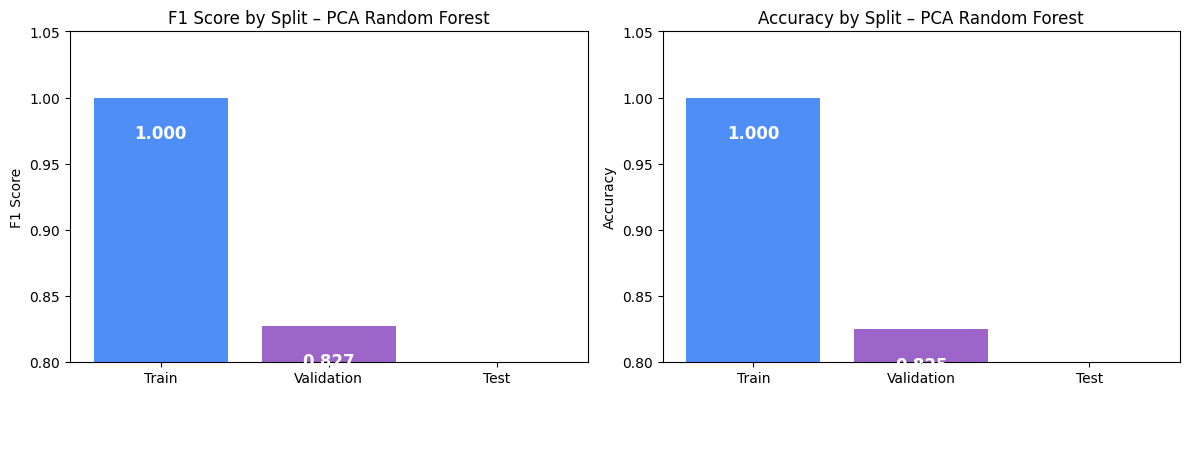

 Performance Summary:
 Best Performing Split: Train (F1: 1.000)
 Generalization Gap (Train-Test): 0.239
 OOB-Test Gap: 0.132
 Model Complexity: 5 PCA components


In [19]:
# ADDITIONAL VISUALIZATION - Performance Summary


def plot_performance_summary(model_results):
    """Create a summary visualization of model performance across splits"""
    
    metrics = model_results['metrics']
    
    # Performance across splits
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # F1 Scores by Split
    splits = ['Train', 'Validation', 'Test']
    f1_scores = [metrics['train_f1'], metrics['val_f1'], metrics['test_f1']]
    colors = ['#4F8EF7', '#9D65C9', '#6CB49B']
    
    bars1 = ax1.bar(splits, f1_scores, color=colors)
    ax1.set_ylim(0.8, 1.05)
    ax1.set_ylabel("F1 Score")
    ax1.set_title("F1 Score by Split – PCA Random Forest")
    
    # Add value labels on bars
    for bar, value in zip(bars1, f1_scores):
        ax1.text(bar.get_x() + bar.get_width()/2, value-0.02, f"{value:.3f}", 
                ha='center', va='top', color='white', fontsize=12, fontweight='bold')
    
    # Accuracy comparison
    accuracies = [metrics['train_accuracy'], metrics['val_accuracy'], metrics['test_accuracy']]
    bars2 = ax2.bar(splits, accuracies, color=colors)
    ax2.set_ylim(0.8, 1.05)
    ax2.set_ylabel("Accuracy")
    ax2.set_title("Accuracy by Split – PCA Random Forest")
    
    # Add value labels on bars
    for bar, value in zip(bars2, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2, value-0.02, f"{value:.3f}", 
                ha='center', va='top', color='white', fontsize=12, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(VISUALIZATIONS_DIR / "performance_summary.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics
    print(" Performance Summary:")
    print("="*40)
    print(f" Best Performing Split: {splits[np.argmax(f1_scores)]} (F1: {max(f1_scores):.3f})")
    print(f" Generalization Gap (Train-Test): {metrics['train_f1'] - metrics['test_f1']:.3f}")
    print(f" OOB-Test Gap: {metrics['oob_score'] - metrics['test_accuracy']:.3f}")
    print(f" Model Complexity: {model_results['pca_info']['n_components']} PCA components")

# Generate performance summary
plot_performance_summary(model_results)